In [1]:
import numpy as np
import pandas as pd
import json
import re
import os
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from datetime import timezone, datetime
import time
from time import strftime, gmtime
from pprint import pprint
import io
import scipy.stats
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
common = './data/'
vr_folder = common + 'vr/'
bio_folder = common + 'biometry/'
vr_files = np.sort(os.listdir(vr_folder))
bio_files = np.sort(os.listdir(bio_folder))

In [3]:
vr_files[0]

'2020_6_17_11_1_2_632.csv'

In [4]:
example = '2020_6_17_11_1_2_632(copy_1).csv'
example = '2020_6_17_11_1_2_632.csv'

In [5]:
bio_files[2]

'2019-06-17_12.06.26_01_P03.txt'

In [6]:
#example = '2019-06-17_12.06.26_01_P03(copy_1).txt'

In [7]:
vr_files[2]

'2020_6_17_12_44_21_197.csv'

In [8]:
os.path.basename(vr_folder + vr_files[0])

'2020_6_17_11_1_2_632.csv'

In [9]:
def unixtime_from_vr(string, copy=False) :
    if copy :
        name = string.split('(')[0]
        ext = string.split(')')[1]
        string = name + ext
    base = string.split('.')[0]
    time = base.split('_')
    #dt = datetime(int(time[0]), int(time[1]), int(time[2]))
    dt = datetime(int(time[0]), int(time[1]), int(time[2]), int(time[3]), int(time[4]), int(time[5]))
    timestamp = dt.replace(tzinfo=timezone.utc).timestamp()
    return int(timestamp) - 3600
    

In [10]:
unixtime_from_vr(example, copy=False)

1592388062

In [11]:
def unixtime_from_bio(string, copy=False) :
    if copy :
        name = string.split('(')[0]
        ext = string.split(')')[1]
        string = name + ext
    base = '.'.join(string.split('.')[:-1])
    #print(base)
    tmp = string.split('-')
    year = 2020
    month = tmp[1]
    tmp1 = tmp[2].split('_')
    day = tmp1[0]
    tmp2 = tmp1[1].split('.')
    hour = tmp2[0]
    minutes = tmp2[1]
    secs = tmp2[2]
    dt = datetime(int(year), int(month), int(day), int(hour), int(minutes), int(secs))
    timestamp = dt.replace(tzinfo=timezone.utc).timestamp()
    return int(timestamp)

In [12]:
example = '2019-06-17_12.06.26_01_P03(copy_1).txt'
example = '2019-06-17_12.06.26_01_P03.txt'
unixtime_from_bio(example, copy=False)

1592395586

In [13]:
def clock2seconds(clock) :
    pt = datetime.strptime(clock,'%H:%M:%S')
    total_seconds = pt.second + pt.minute*60 + pt.hour*3600
    return total_seconds

In [14]:
def seconds2clock(seconds) :
    return strftime('%H:%M:%S', gmtime(seconds))

In [15]:
competence_map = ["Self-confidence", "Self-control", "Openness to change", "Responsibility", "Communicability"]

def get_vr_evals(file, from_memory=False, init_time=None):
    
    competences = {
        "Self-confidence" : 
        {
            'scenarios' : []
        },

        "Self-control" : 
        {
            'scenarios' : []
        },
        "Openness to change" : 
        {
            'scenarios' : []
        },
        "Responsibility" : 
        {
            'scenarios' : []
        },
        "Communicability" : 
        {
            'scenarios' : []
        },
    }
    
    if not from_memory :
        file1 = open(file, 'r') 
        Lines = file1.readlines()
    else :
        file1 = io.StringIO(file)
        Lines = file1.readlines()
    Lines = list(map(lambda x : x.replace('\n', ''), Lines))
    scenario_counter = -1
    scene_counter = -1
    respondent_id = 0
    if from_memory :
        #print(os.path.basename(init_time))
        unix_time_start = unixtime_from_vr(os.path.basename(init_time))
    else :
        #print(os.path.basename(file))
        unix_time_start = unixtime_from_vr(os.path.basename(file))
    for line in Lines :
        if 'Respondent' in line :
            respondent_id =  line.split(':')[-1].strip(' ')
        if 'Scenario' in line :
            if 'Scenario ID' in line :
                scenario_counter += 1
                scene_counter = -1
                for key in list(competences.keys()) :
                    competences[key]['scenarios'].append({'scenes' : []})
            if (('Scenario Start' in line) or ('Scenario End' in line)) :
                time = ':'.join(line.split(':')[1:]).strip(' ')
                suffix = 'start' if 'Start' in line else 'end'
                for key in list(competences.keys()) :
                    competences[key]['scenarios'][scenario_counter]['scenario_time_' + suffix] = time
                    competences[key]['scenarios'][scenario_counter]['scenario_time_unix_' + suffix] = \
                                                                                unix_time_start + clock2seconds(time)
        if 'Scene' in line :
            if line.split(':')[-1].strip(' ') == '' :
                continue
            if line.split(':')[0].strip(' ') == 'Scene' :
                scene_counter += 1
                scene_id = '.'.join(line.split(':')[-1].strip(' ').split('.')[:-1])
                #print(scene_id)
                for key in list(competences.keys()) :
                    competences[key]['scenarios'][scenario_counter]['scenes'].append({'id' : scene_id, 'vr_evals' : []})
            if (('SceneStart' in line) or ('SceneEnd' in line)):
                time = ':'.join(line.split(':')[1:]).strip(' ')
                suffix = 'start' if 'Start' in line else 'end'
                for key in list(competences.keys()) :
                    competences[key]['scenarios'][scenario_counter]['scenes'][scene_counter]['scene_time_'+suffix] = \
                                                                                                                time
                    competences[key]['scenarios'][scenario_counter]['scenes'][scene_counter]['scene_time_unix_'+suffix] = \
                                                                                unix_time_start + clock2seconds(time)

        if re.match(r'.*\..', line.split(':')[0].strip(' ')) and len(line.split(':')[0].strip(' ')) == 3 :
            #print(line)
            key = competence_map[int(line.split(':')[0].strip(' ').split('.')[0]) - 1]
            value = int(line.split(':')[1].strip(' '))
            competences[key]['scenarios'][scenario_counter]['scenes'][scene_counter]['vr_evals'].append(value)
        #else :
            #print(line)
        
    return competences
                
            

In [16]:
def is_overlapping(x1,x2,y1,y2):
    return max(x1,y1) <= min(x2,y2)

In [17]:
def get_intermediate_biometry(start, end, biometry) :
    length = len(biometry['timestamps'])
    
    evals = []
    for idx in range(length) :
        left = biometry['timestamps'][idx]
        if idx == length - 1 :
            right = left + 60
        else :
            right = biometry['timestamps'][idx + 1]
        
        if ((left in range(start, end)) and (right in range(start, end))) :
            evals.append(biometry['Pulse'][0][idx])
        elif ((left in range(start, end)) and not (right in range(start, end))) :
            if idx == length - 1 :
                evals.append(biometry['Pulse'][0][idx])
            else :
                evals.append((biometry['Pulse'][0][idx] + biometry['Pulse'][0][idx + 1]) / 2)
        elif is_overlapping(start, end, left, right) :
            evals.append(biometry['Pulse'][0][idx])
        elif (not (left in range(start, end)) and not (right in range(start, end))) :
            #print(start, end, left, right)
            continue
        
    return evals

In [18]:
def get_biometry_evals(file, from_memory=False, init_time=None) :
    if from_memory :
        biometry = file
    else :
        with open(file, 'r') as fi :
            biometry = json.load(fi)
    if from_memory :
        unix_time_start = unixtime_from_bio(os.path.basename(init_time))
    else :
        unix_time_start = unixtime_from_bio(os.path.basename(file))
    biometry['timestamps'] = list(map(lambda x : x * 60 + unix_time_start, biometry['Minutes'][0]))
    return biometry

In [19]:
def get_fusion_evals(vr_file, bio_file, from_memory=False, init_vr_time=None, init_bio_time=None) :
    
    competences = get_vr_evals(vr_file, from_memory, init_vr_time)
    #print(competences)
    biometry = get_biometry_evals(bio_file, from_memory, init_bio_time)
    #print(biometry)
    for key in list(competences.keys()) :
        for scenario_idx in range(len(competences[key]['scenarios'])) :
            for scene_idx in range(len(competences[key]['scenarios'][scenario_idx]['scenes'])) :
                if len(competences[key]['scenarios'][scenario_idx]['scenes'][scene_idx]['vr_evals']) > 0 :
                    time_start = competences[key]['scenarios'][scenario_idx]['scenes'][scene_idx]['scene_time_unix_start']
                    time_end = competences[key]['scenarios'][scenario_idx]['scenes'][scene_idx]['scene_time_unix_end']
                    bio_evals = get_intermediate_biometry(time_start, time_end, biometry)
                    #print(bio_evals)
                    competences[key]['scenarios'][scenario_idx]['scenes'][scene_idx]['bio_evals'] = bio_evals
    return competences

In [20]:
def validate_fusion_data(competences) :
    for key in list(competences.keys()) :
        for scenario_idx in range(len(competences[key]['scenarios'])) :
            for scene_idx in range(len(competences[key]['scenarios'][scenario_idx]['scenes'])) :
                if len(competences[key]['scenarios'][scenario_idx]['scenes'][scene_idx]['vr_evals']) > 0 :
                    if len(competences[key]['scenarios'][scenario_idx]['scenes'][scene_idx]['bio_evals']) == 0 :
                        return False
    return True

In [21]:
respondents = []
trash = 0
good = 0
new_indices = []
for idx in range(len(vr_files)) :
    respondent = get_fusion_evals(vr_folder + vr_files[idx], bio_folder + bio_files[idx])
    if not validate_fusion_data(respondent) :
        print("Respondent № " + str(idx + 1) + ' is trash')
        trash += 1
        #respondents.append(respondent)
    else :
        print("Respondent № " + str(idx + 1) + ' is good')
        good += 1
        respondents.append(respondent)
        new_indices.append(idx)
print(good)
print(trash)
print(new_indices)

Respondent № 1 is trash
Respondent № 2 is good
Respondent № 3 is trash
Respondent № 4 is good
Respondent № 5 is good
Respondent № 6 is good
Respondent № 7 is trash
Respondent № 8 is good
Respondent № 9 is trash
Respondent № 10 is good
Respondent № 11 is good
Respondent № 12 is trash
Respondent № 13 is trash
Respondent № 14 is trash
Respondent № 15 is trash
Respondent № 16 is trash
Respondent № 17 is good
Respondent № 18 is good
Respondent № 19 is trash
Respondent № 20 is good
Respondent № 21 is trash
Respondent № 22 is trash
Respondent № 23 is trash
Respondent № 24 is good
Respondent № 25 is trash
Respondent № 26 is good
Respondent № 27 is good
Respondent № 28 is good
Respondent № 29 is good
Respondent № 30 is trash
Respondent № 31 is good
Respondent № 32 is trash
Respondent № 33 is good
Respondent № 34 is trash
Respondent № 35 is trash
Respondent № 36 is trash
Respondent № 37 is good
Respondent № 38 is good
Respondent № 39 is trash
Respondent № 40 is good
Respondent № 41 is good
Respo

In [22]:
template = ['1_1', '1_2', '1_3', 
            '2_1', '2_1.1', '2_1.2', '2_2', '2_2.1', '2_2.2', 
            '3_1', '3_2', '3_3', '3_4', '3_5', '3_6', '3_7', 
            '4_1', '4_2', '4_3', '4_4', 
            '5_1', '5_2', '5_3', '5_4', '5_5', '5_6', 
            '6_1', '6_2', '6_3', '6_4', '6_5', '6_6', 
            '7_1', '7_2', '7_3', '7_4', '7_5', 
            '8_1', '8_2', '8_3', '8_4', '8_5', 
            '9_1', '9_2', '9_3', 
            '10_1', '10_2', '10_3', '10_4']
print(len(template))

49


In [23]:
def gen_template(template, suffixes) :
    extended_template = []
    for scene in template :
        for suffix in suffixes :
            if suffix == '' :
                extended_template.append(scene)
            else :
                extended_template.append(scene + '_' + suffix)
    return extended_template

In [25]:
len(gen_template(template, ['vr', 'bio', 'time']))

147

In [24]:
def respondents_to_df(respondents, template, only_vr=False) :
    evals = [{ key : dict.fromkeys(template) for key in respondents[0].keys()} for i in range(len(respondents))] 
    reduntant = []
    for idx, respondent in enumerate(respondents) :
        competences = respondent
        for key in list(competences.keys()) :
            for scenario_idx in range(len(competences[key]['scenarios'])) :
                cur_scenario_id = str(scenario_idx)
                for scene_idx in range(len(competences[key]['scenarios'][scenario_idx]['scenes'])) :
                    #print(competences[key]['scenarios'][scenario_idx]['scenes'][scene_idx])
                    if len(competences[key]['scenarios'][scenario_idx]['scenes'][scene_idx]['vr_evals']) > 0 :
                        cur_scene_id = competences[key]['scenarios'][scenario_idx]['scenes'][scene_idx]['id'] 
                        vr_value = np.mean(competences[key]['scenarios'][scenario_idx]['scenes'][scene_idx]['vr_evals'])
                        if not only_vr :
                            if len(competences[key]['scenarios'][scenario_idx]['scenes'][scene_idx]['bio_evals']) == 0 :
                                bio_value = np.nan
                            else :
                                bio_value = np.mean(competences[key]['scenarios'][scenario_idx]['scenes'][scene_idx]['bio_evals'])
                            time_start = competences[key]['scenarios'][scenario_idx]['scenes'][scene_idx]['scene_time_unix_start']
                            time_end = competences[key]['scenarios'][scenario_idx]['scenes'][scene_idx]['scene_time_unix_end']
                            time_diff = time_end - time_start
                        #evals[idx][key][cur_scenario_id + '_' + cur_scene_id] = vr_value
                        if (cur_scenario_id + '_' + cur_scene_id + '_vr') in list(evals[idx][key].keys()) :
                            if only_vr :
                                evals[idx][key][cur_scenario_id + '_' + cur_scene_id + '_vr'] = vr_value
                            else :
                                evals[idx][key][cur_scenario_id + '_' + cur_scene_id + '_vr'] = vr_value
                                evals[idx][key][cur_scenario_id + '_' + cur_scene_id + '_bio'] = bio_value
                                evals[idx][key][cur_scenario_id + '_' + cur_scene_id + '_time'] = time_diff
                        else :
                            reduntant.append(cur_scenario_id + '_' + cur_scene_id + '_vr')
    print(list(set(reduntant)))
    return evals
        

In [25]:
#tmp = respondents_to_df(respondents, gen_template(template, ['']), only_vr=True)
tmp = respondents_to_df(respondents, gen_template(template, ['vr', 'bio', 'time']))
#print(len(tmp))
competences = list(tmp[0].keys())
print(len(tmp[7]['Self-confidence'].keys()))
tmp[0]['Self-confidence'].keys()

[]
147


dict_keys(['1_1_vr', '1_1_bio', '1_1_time', '1_2_vr', '1_2_bio', '1_2_time', '1_3_vr', '1_3_bio', '1_3_time', '2_1_vr', '2_1_bio', '2_1_time', '2_1.1_vr', '2_1.1_bio', '2_1.1_time', '2_1.2_vr', '2_1.2_bio', '2_1.2_time', '2_2_vr', '2_2_bio', '2_2_time', '2_2.1_vr', '2_2.1_bio', '2_2.1_time', '2_2.2_vr', '2_2.2_bio', '2_2.2_time', '3_1_vr', '3_1_bio', '3_1_time', '3_2_vr', '3_2_bio', '3_2_time', '3_3_vr', '3_3_bio', '3_3_time', '3_4_vr', '3_4_bio', '3_4_time', '3_5_vr', '3_5_bio', '3_5_time', '3_6_vr', '3_6_bio', '3_6_time', '3_7_vr', '3_7_bio', '3_7_time', '4_1_vr', '4_1_bio', '4_1_time', '4_2_vr', '4_2_bio', '4_2_time', '4_3_vr', '4_3_bio', '4_3_time', '4_4_vr', '4_4_bio', '4_4_time', '5_1_vr', '5_1_bio', '5_1_time', '5_2_vr', '5_2_bio', '5_2_time', '5_3_vr', '5_3_bio', '5_3_time', '5_4_vr', '5_4_bio', '5_4_time', '5_5_vr', '5_5_bio', '5_5_time', '5_6_vr', '5_6_bio', '5_6_time', '6_1_vr', '6_1_bio', '6_1_time', '6_2_vr', '6_2_bio', '6_2_time', '6_3_vr', '6_3_bio', '6_3_time', '6_4_vr'

In [27]:
keys = []
for resp in tmp :
    keys += list(resp['Self-confidence'].keys())
keys = list(set(keys))

In [29]:
def bio2csv(file) :
    json_file = get_biometry_evals(bio_folder + file)
    minutes = pd.Series(json_file['Minutes'][0])
    pulse = pd.Series(json_file['Pulse'][0])
    eda = pd.Series(json_file['EDA'][0])
    df = pd.concat([minutes, pulse, eda], keys=['Minutes', 'Pulse', 'EDA'], axis=1)
    df.index += 1
    return df

In [30]:
bios = []
for file in bio_files :
    if np.mean(get_biometry_evals(bio_folder + file)['Pulse']) == 0 :
        print(file)
    bios.append(np.mean(get_biometry_evals(bio_folder + file)['Pulse']))
bios = pd.Series(bios)
bios.index += 1

2019-06-18_15.04.37_01_P12.txt
2019-06-22_15.20.01_01_P27.txt
2019-06-23_15.47.26_01_P35.txt
2019-06-29_16.09.57_01_P42.txt


In [31]:
tables = []
for comp_idx in range(len(competences)) :
    resp_series = []
    columns = list(tmp[0][competences[comp_idx]].keys())
    some = 0
    for respondent in tmp :
        #print(some)
        #some +=1
        resp_series.append(pd.Series(list(respondent[competences[comp_idx]].values())))
    print(len(resp_series))
    table = pd.concat(resp_series, axis=1).T
    table.columns = columns
    table.index += 1
    tables.append(table)

25
25
25
25
25


In [32]:
tables[0].head()

,1_1_vr,1_1_bio,1_1_time,1_2_vr,1_2_bio,1_2_time,1_3_vr,1_3_bio,1_3_time,2_1_vr,...,10_1_time,10_2_vr,10_2_bio,10_2_time,10_3_vr,10_3_bio,10_3_time,10_4_vr,10_4_bio,10_4_time
1,2.0,1.333333,94.0,2.0,1.5,41.0,3.0,2.000000,90.0,NaN,...,57.0,3.000000,1.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,0.625000,132.0,3.0,1.0,40.0,3.0,0.666667,76.0,3.0,...,70.0,2.666667,0.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,0.666667,122.0,2.0,2.0,57.0,3.0,1.500000,120.0,NaN,...,62.0,3.000000,0.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,3.000000,109.0,2.0,3.0,48.0,3.0,3.000000,100.0,NaN,...,77.0,3.000000,3.0,42.0,3.0,3.0,77.0,NaN,NaN,NaN
5,2.0,2.500000,145.0,3.0,3.0,49.0,2.0,2.250000,139.0,NaN,...,90.0,1.000000,1.0,40.0,3.0,1.0,22.0,NaN,NaN,NaN


In [33]:
tables[3].head()

,1_1_vr,1_1_bio,1_1_time,1_2_vr,1_2_bio,1_2_time,1_3_vr,1_3_bio,1_3_time,2_1_vr,...,10_1_time,10_2_vr,10_2_bio,10_2_time,10_3_vr,10_3_bio,10_3_time,10_4_vr,10_4_bio,10_4_time
1,2.0,1.333333,94.0,2.0,1.5,41.0,3.0,2.000000,90.0,NaN,...,57.0,3.0,1.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,0.625000,132.0,3.0,1.0,40.0,3.0,0.666667,76.0,2.0,...,70.0,3.0,0.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,0.666667,122.0,2.5,2.0,57.0,3.0,1.500000,120.0,NaN,...,62.0,3.0,0.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,3.000000,109.0,2.0,3.0,48.0,3.0,3.000000,100.0,NaN,...,77.0,3.0,3.0,42.0,3.0,3.0,77.0,NaN,NaN,NaN
5,2.0,2.500000,145.0,3.0,3.0,49.0,2.0,2.250000,139.0,NaN,...,90.0,1.0,1.0,40.0,3.0,1.0,22.0,NaN,NaN,NaN


In [26]:
tables = []
means_vr = []
for comp_idx in range(len(competences)) :
    resp_series = []
    columns = list(tmp[0][competences[comp_idx]].keys())
    some = 0
    for respondent in tmp :
        #print(some)
        #some +=1
        resp_series.append(pd.Series(list(respondent[competences[comp_idx]].values())))
    print(len(resp_series))
    table = pd.concat(resp_series, axis=1).T
    table.columns = columns
    table.index += 1
    vr_columns = [col for col in columns if 'vr' in col]
    means_vr.append(table[vr_columns].mean(axis=1))
    #table.style.highlight_na('black')
    print(table.shape)
    #table = table.fillna(0)
    tables.append(table)
means_df = pd.concat(means_vr, axis=1, keys=['Self-confidence', 'Self-control', 'Openness to change', 'Responsibility', 'Communicability'])
means_df['total_vr'] = means_df.apply(np.mean, axis=1)
means_df['total_bio'] = bios
time_columns = [col for col in columns if 'time' in col]
means_df['total_time'] = tables[0][time_columns].mean(axis=1)
#means_df = means_df.sort_values(by=['Total'])
for ix, table in enumerate(tables) :
    tables[ix] = tables[ix][vr_columns]
    new_columns = gen_template(template, [''])
    tables[ix].columns = new_columns
    tables[ix]['total_vr'] = means_df['total_vr']
    tables[ix] = tables[ix].sort_values(by=['total_vr'])
means_df = means_df.sort_values(by=['total_vr'])    

50
(50, 49)
50
(50, 49)
50
(50, 49)
50
(50, 49)
50
(50, 49)


ValueError: Length mismatch: Expected axis has 0 elements, new values have 49 elements

In [20]:
def highlight_nan(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    flags = np.isnan(s)
    return ['background-color: gray' if v else '' for v in flags]

In [31]:
with pd.ExcelWriter('vr_stimulus.xlsx') as writer:  
    for idx, table in enumerate(tables) :
        table.style.apply(highlight_nan).to_excel(writer, sheet_name=competences[idx], engine='openpyxl')
        #table.to_excel(writer, sheet_name=competences[idx])
    means_df.to_excel(writer, sheet_name='Mean Values', engine='openpyxl')

ModuleNotFoundError: No module named 'openpyxl'

## Generation

In [26]:
example = '2020_6_17_15_1_56_588.csv'

In [27]:
def copy_vr_data(filename) :
    competence_map = ["Self-confidence", "Self-control", "Openness to change", "Responsibility", "Communicability"]
    common = './data/'
    vr_folder = common + 'vr/'
    competences = []
    file_descriptor = open(vr_folder + filename, 'r') 
    Lines = file_descriptor.readlines()
    Lines = list(map(lambda x : x.strip(), Lines))
    probs = [[0.7, 0.2, 0.1], [0.15, 0.7, 0.15], [0.1, 0.2, 0.7]]
    scenario_counter = -1
    scene_counter = -1
    respondent_id = 0
    unix_time_start = unixtime_from_vr(os.path.basename(filename))
    for ix, line in enumerate(Lines) :
        if 'Respondent' in line :
            respondent_id =  line.split(':')[-1].strip(' ')
        if 'Scenario' in line :
            if 'Scenario ID' in line :
                scenario_counter += 1
                scene_counter = -1
                competences.append({'scenes' : []})
                if scenario_counter != 0 :
                    competences[scenario_counter - 1]['scenario_time_end'] = \
                        competences[scenario_counter - 1]['scenes'][-1]['scene_time_end']
                    new_line = Lines[prev_scenario_line_index].replace(prev_scenario_time, competences[scenario_counter - 1]['scenario_time_end'])
                    Lines[prev_scenario_line_index] = new_line
            if (('Scenario Start' in line) or ('Scenario End' in line)) :
                time = ':'.join(line.split(':')[1:]).strip(' ')
                if 'Scenario Start' in line :
                    suffix = 'start'
                    if scenario_counter == 0 :
                        competences[scenario_counter]['scenario_time_' + suffix] = time
                    else :
                        competences[scenario_counter]['scenario_time_' + suffix] = \
                            competences[scenario_counter - 1]['scenes'][-1]['scene_time_end']
                        new_line = line.replace(time, competences[scenario_counter]['scenario_time_' + suffix])
                        Lines[ix] = new_line
                if 'Scenario End' in line :
                    prev_scenario_line_index = ix
                    prev_scenario_time = time

        if 'Scene' in line :
            if line.split(':')[-1].strip(' ') == '' :
                continue
            if line.split(':')[0].strip(' ') == 'Scene' :
                scene_counter += 1
                scene_id = '.'.join(line.split(':')[-1].strip(' ').split('.')[:-1])
                competences[scenario_counter]['scenes'].append({'id' : scene_id, 'vr_evals' : []})
            if (('SceneStart' in line) or ('SceneEnd' in line)):
                time = ':'.join(line.split(':')[1:]).strip(' ')

                if 'SceneStart' in line :
                    start_time = time
                    suffix = 'start'
                    if scene_counter == 0 :    
                        competences[scenario_counter]['scenes'][scene_counter]['scene_time_' + suffix] = competences[scenario_counter]['scenario_time_start']
                    else :
                        competences[scenario_counter]['scenes'][scene_counter]['scene_time_' + suffix] = \
                            competences[scenario_counter]['scenes'][scene_counter - 1]['scene_time_end']
                    new_line = line.replace(time, competences[scenario_counter]['scenes'][scene_counter]['scene_time_' + suffix])
                    Lines[ix] = new_line
                if 'SceneEnd' in line :
                    end_time = time
                    suffix = 'end'
                    diff = clock2seconds(end_time) - clock2seconds(start_time)
                    new_start_time = clock2seconds(competences[scenario_counter]['scenes'][scene_counter]['scene_time_start'])
                    #print(new_start_time)
                    #print(diff)
                    #print(new_start_time + np.random.normal(diff, diff*0.15, 1))
                    competences[scenario_counter]['scenes'][scene_counter]['scene_time_' + suffix] = \
                        seconds2clock(new_start_time + int(np.random.normal(diff, diff*0.15, 1)))
                    
                    new_line = line.replace(time, competences[scenario_counter]['scenes'][scene_counter]['scene_time_' + suffix])
                    Lines[ix] = new_line

        if re.match(r'.*\..', line.split(':')[0].strip(' ')) and len(line.split(':')[0].strip(' ')) == 3 :
            #print(line)
            value = int(line.split(':')[1].strip(' '))
            new_value = np.random.choice([1, 2, 3], 1, p=probs[value - 1])[0]
            new_line = line.replace(': ' + str(value), ': ' + str(new_value))
            Lines[ix] = new_line
    return '\n'.join(Lines)

In [36]:
text_file = open("sample.csv", "w")
n = text_file.write(copy_vr_data(example))
text_file.close()


In [30]:
bio_example = '2019-06-17_15.06.15_01_P06.txt'


In [28]:
def copy_bio_data(filename) :
    probs = [[0.7, 0.2, 0.1], [0.15, 0.7, 0.15], [0.1, 0.2, 0.7]]
    bio_folder = common + 'biometry/'
    #np.random.seed(random_state)
    evals = get_biometry_evals(bio_folder + filename)
    for ix, pulse in enumerate(evals['Pulse'][0]) :
        if pulse == 0 :
            new_pulse = np.random.choice([0, 1, 2], 1, p=[0.7, 0.2, 0.1])[0]
        else :
            new_pulse = np.random.choice([1, 2, 3], 1, p=probs[pulse - 1])[0]
        evals['Pulse'][0][ix] = new_pulse
    
    return evals
        
        

In [39]:
text_file = open("sample.txt", "w")
copy_bio = copy_bio_data(bio_example)
copy_bio.pop('timestamps', None)
n = text_file.write(str(copy_bio))
text_file.close()


In [32]:
gen_vr_data = copy_vr_data(example)
#print(gen_vr_data)
np.random.seed(42)
gen_bio_data = copy_bio_data(bio_example)
gen_bio_data1 = copy_bio_data(bio_example)
print(gen_bio_data)
print(gen_bio_data1)
#print(gen_bio_data)
#bio_files[5]
gen_respondent = get_fusion_evals(gen_vr_data, gen_bio_data, True, vr_files[5], bio_files[5])
#print(gen_vr_data)
#gen_evals = get_vr_evals(gen_vr_data, from_memory=True, init_time=vr_files[5])
#gen_evals
#gen_respondent

{'Minutes': [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]], 'Pulse': [[3, 3, 3, 3, 2, 2, 1, 3, 3, 3, 1, 2, 3, 0, 2, 2, 3, 3, 3, 2, 3, 2, 2, 3, 2, 3, 2, 0, 3, 1, 3, 2, 1, 3, 3, 3, 3, 1, 3, 3, 2, 3, 1, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3]], 'EDA': [[2, 1, 1, 2, 3, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 1, 0, 2, 1, 1, 2, 1, 2, 3, 1, 2, 2, 0, 1, 1, 3, 3, 0, 0, 0, 0, 0, 2, 3, 3, 3, 3, 2, 2, 2, 0, 2, 2, 1, 1, 0, 3]], 'timestamps': [1592406375, 1592406435, 1592406495, 1592406555, 1592406615, 1592406675, 1592406735, 1592406795, 1592406855, 1592406915, 1592406975, 1592407035, 1592407095, 1592407155, 1592407215, 1592407275, 1592407335, 1592407395, 1592407455, 1592407515, 1592407575, 1592407635, 1592407695, 1592407755, 1592407815, 1592407875, 1592407935, 1592407995, 1592408055, 1592408115, 1592408175, 1592408235, 1592408295, 1592408355, 1592408415, 15924

In [37]:
tables = []
for comp in competences :
    tables.append(pd.read_csv('./data/' + comp + '.csv', index_col=0))

In [41]:
add_feat['M061'].value_counts()

2    15
4    15
0    10
3     7
1     3
Name: M061, dtype: int64

In [30]:
add_feat = pd.read_csv('./data/additional_features.csv', header=None)
columns = ['MK01', 'K02', 'M03','M04', 'M05', 'M061', 'M062', 'K07', 'M08', 'M09', 'M10', 'M11']
add_feat.columns = columns
new_indices = add_feat[add_feat['M061'] == 4].index.tolist()
vr_files = vr_files[new_indices]
bio_files = bio_files[new_indices]

In [99]:
len(vr_files)

15

In [31]:
np.random.seed(42)
respondents = []
#trash = 0
#good = 0
fail_counter = 0
i = 0
n_samples = 1333
fail_threshold = 100
for idx in tqdm(range(len(vr_files))) :
    respondent = get_fusion_evals(vr_folder + vr_files[idx], bio_folder + bio_files[idx])
    respondents.append(respondent)
    for i in range(n_samples) :
        gen_vr_data = copy_vr_data(vr_files[idx])
        
        gen_bio_data = copy_bio_data(bio_files[idx])
        gen_respondent = get_fusion_evals(gen_vr_data, gen_bio_data, True, vr_files[idx], bio_files[idx])    
        respondents.append(gen_respondent)
            
#print(good)
#print(trash)

  0%|          | 0/15 [00:00<?, ?it/s]

In [105]:
15 * 1333

19995

In [47]:
import uuid
import os
uuid.uuid4().hex

'532b15573ae347fe89ffcc712dcb7405'

In [49]:
os.mkdir('./big_data/main/' + uuid.uuid4().hex)

In [51]:
np.random.seed(42)
respondents = []
#trash = 0
#good = 0
fail_counter = 0
i = 0
n_samples = 800
fail_threshold = 100
for idx in tqdm(range(len(new_indices))) :
    respondent = get_fusion_evals(vr_folder + vr_files[new_indices[idx]], bio_folder + bio_files[new_indices[idx]])
    if validate_fusion_data(respondent) :
        #print("Respondent № " + str(idx + 1) + ' is good')
        #good += 1
        respondents.append(respondent)
        if fail_counter > fail_threshold :    
            i = i - n_samples
            print(i)
            fail_counter = 0
        else :
            i = 0
            fail_counter = 0
        while i != n_samples  :
            if fail_counter > fail_threshold :
                print('Fail detected')
                break
            
            gen_vr_data = copy_vr_data(vr_files[new_indices[idx]])
            gen_bio_data = copy_bio_data(bio_files[new_indices[idx]])
            gen_respondent = get_fusion_evals(gen_vr_data, gen_bio_data, True, vr_files[new_indices[idx]], bio_files[new_indices[idx]])
            if validate_fusion_data(gen_respondent) :
                respondents.append(gen_respondent)
                i+=1
                fail_counter = 0
                #print(i)
                
                folder_guid = uuid.uuid4().hex
                os.mkdir('./big_data/main/' + folder_guid)
                file_tmp = vr_files[new_indices[idx]].split('.')
                copy_part = '(copy_' + str(i) + ')'
                new_filename = file_tmp[0] + copy_part + '.' + file_tmp[1]
                text_file = open('./big_data/main/' + folder_guid + '/' + new_filename, "w")
                n = text_file.write(gen_vr_data)
                text_file.close()
                
                file_tmp = bio_files[new_indices[idx]].split('.')
                base = '.'.join(file_tmp[:-1])
                copy_part = '(copy_' + str(i) + ')'
                new_filename = base + copy_part + '.' + file_tmp[-1]
                text_file = open('./big_data/main/' + folder_guid + '/' + new_filename, "w")
                n = text_file.write(str(gen_bio_data))
                text_file.close()
            else :
                fail_counter += 1
                if fail_counter > 50 :
                    print(fail_counter)
                #print(fail_counter)
            
#print(good)
#print(trash)

  0%|          | 0/25 [00:00<?, ?it/s]

51
52
53
54
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
51
52
53
54
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
51
52
53
54
55
56
57
58
59
60
51
52
53
54
55
56
57
51
52
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
51
52
53
54
55
56
57
51
52
53
54
55
56
57
58
59
60
61
51
52
53
51
52
53
54
55
56
57
58
59
51
52
53
54
55
56
57
58
59
60
61
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
Fail detected
-800
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
51
52
53
54
55
56
57
58
59
60
61
6

In [107]:
len(respondents)

20010

In [44]:
#respondets_np = np.array(respondents)

In [63]:
#np.save('./data/dataset_vr_bio_relearning.npy', respondets_np, allow_pickle=True)

In [46]:
#np.save('./data/dataset_vr_bio_relearning_2.npy', respondets_np, allow_pickle=True)

In [57]:
np.save('./data/dataset_vr_bio_sync_final.npy', respondents)

In [97]:
np.save('./data/dataset_vr_first_learning.npy', respondents)

In [23]:
respondents = np.load('./data/dataset_vr_bio_sync_final.npy', allow_pickle=True)

In [32]:
competence_data = respondents_to_df(respondents, gen_template(template, ['vr']), only_vr=True)
#print(len(tmp))
competences = list(competence_data[0].keys())
print(len(competence_data[7]['Self-confidence'].keys()))
competence_data[0]['Self-confidence'].keys()

[]
49


dict_keys(['1_1_vr', '1_2_vr', '1_3_vr', '2_1_vr', '2_1.1_vr', '2_1.2_vr', '2_2_vr', '2_2.1_vr', '2_2.2_vr', '3_1_vr', '3_2_vr', '3_3_vr', '3_4_vr', '3_5_vr', '3_6_vr', '3_7_vr', '4_1_vr', '4_2_vr', '4_3_vr', '4_4_vr', '5_1_vr', '5_2_vr', '5_3_vr', '5_4_vr', '5_5_vr', '5_6_vr', '6_1_vr', '6_2_vr', '6_3_vr', '6_4_vr', '6_5_vr', '6_6_vr', '7_1_vr', '7_2_vr', '7_3_vr', '7_4_vr', '7_5_vr', '8_1_vr', '8_2_vr', '8_3_vr', '8_4_vr', '8_5_vr', '9_1_vr', '9_2_vr', '9_3_vr', '10_1_vr', '10_2_vr', '10_3_vr', '10_4_vr'])

In [33]:
tables = []
for comp_idx in range(len(competences)) :
    resp_series = []
    columns = list(competence_data[0][competences[comp_idx]].keys())
    some = 0
    for respondent in competence_data :
        #print(some)
        #some +=1
        resp_series.append(pd.Series(list(respondent[competences[comp_idx]].values())))
    print(len(resp_series))
    table = pd.concat(resp_series, axis=1).T
    table.columns = columns
    table.index += 1
    tables.append(table)

20010
20010
20010
20010
20010


In [39]:
tables[0].head()

,1_1_vr,1_2_vr,1_3_vr,2_1_vr,2_1.1_vr,2_1.2_vr,2_2_vr,2_2.1_vr,2_2.2_vr,3_1_vr,...,8_3_vr,8_4_vr,8_5_vr,9_1_vr,9_2_vr,9_3_vr,10_1_vr,10_2_vr,10_3_vr,10_4_vr
1,3.000000,2.000000,3.000000,NaN,NaN,NaN,2.0,2.0,NaN,3.0,...,3.0,2.0,3.0,3.0,NaN,2.0,3.000000,2.666667,NaN,NaN
2,2.333333,2.000000,2.666667,NaN,NaN,NaN,2.0,2.0,NaN,2.5,...,3.0,1.5,3.0,2.5,NaN,1.0,2.333333,3.000000,NaN,NaN
3,3.000000,2.000000,1.666667,NaN,NaN,NaN,1.5,1.5,NaN,2.0,...,1.0,2.5,2.0,3.0,NaN,1.5,2.666667,3.000000,NaN,NaN
4,3.000000,3.000000,3.000000,NaN,NaN,NaN,2.0,2.0,NaN,2.5,...,3.0,2.5,3.0,1.5,NaN,2.0,3.000000,2.666667,NaN,NaN
5,2.333333,2.666667,3.000000,NaN,NaN,NaN,2.0,2.5,NaN,2.5,...,2.5,1.0,2.5,2.0,NaN,1.5,2.333333,2.666667,NaN,NaN


In [31]:
for ix, table in enumerate(tables) :
    table.to_csv('./for_testing/' + competences[ix] + '.csv', index=False)

In [32]:
competences

['Self-confidence',
 'Self-control',
 'Openness to change',
 'Responsibility',
 'Communicability']

In [108]:
file_descriptor = open(vr_folder + example, 'r') 
Lines = file_descriptor.readlines()
Lines = list(map(lambda x : x.strip(), Lines))

## Additional features

In [45]:
add_feat = pd.read_csv('./data/additional_features.csv', header=None)
columns = ['MK01', 'K02', 'M03','M04', 'M05', 'M061', 'M062', 'K07', 'M08', 'M09', 'M10', 'M11']
add_feat.columns = columns

In [46]:
add_feat.describe()

,MK01,K02,M03,M04,M05,M061,M062,K07,M08,M09,M10,M11
count,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,3.240000,1.280000,3.14000,2.860000,1.200000,2.280000,10.620000,5.860000,3.040000,7.700000,3.100000,1.540000
std,1.779245,0.453557,1.12504,1.030356,0.404061,1.471359,25.784737,3.886187,0.968061,5.421988,0.909137,0.503457
min,1.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,1.000000
25%,2.000000,1.000000,3.00000,2.000000,1.000000,1.250000,1.000000,2.000000,2.000000,4.000000,2.000000,1.000000
50%,3.000000,1.000000,3.00000,3.000000,1.000000,2.000000,3.000000,6.000000,3.000000,7.000000,3.000000,2.000000
75%,5.000000,2.000000,4.00000,4.000000,1.000000,4.000000,9.000000,10.000000,4.000000,8.000000,4.000000,2.000000
max,7.000000,2.000000,5.00000,4.000000,2.000000,4.000000,130.000000,11.000000,4.000000,18.000000,5.000000,2.000000


In [47]:
add_feat.head()

,MK01,K02,M03,M04,M05,M061,M062,K07,M08,M09,M10,M11
0,3,1,3,1,2,1,0,2,2,4,2,2
1,3,1,3,2,1,3,5,10,3,8,2,2
2,3,1,1,4,1,4,5,1,4,4,3,1
3,1,1,5,2,1,4,1,10,2,8,3,2
4,3,1,3,4,1,2,4,8,2,7,3,2


In [48]:
add_feat['id'] = np.ones(add_feat.shape[0], dtype=int) + np.array(list(add_feat.index), dtype=int)
add_feat['id'] = add_feat['id'].apply(str)

In [49]:
add_feat.head()

,MK01,K02,M03,M04,M05,M061,M062,K07,M08,M09,M10,M11,id
0,3,1,3,1,2,1,0,2,2,4,2,2,1
1,3,1,3,2,1,3,5,10,3,8,2,2,2
2,3,1,1,4,1,4,5,1,4,4,3,1,3
3,1,1,5,2,1,4,1,10,2,8,3,2,4
4,3,1,3,4,1,2,4,8,2,7,3,2,5


In [97]:
np.random.seed(42)
dfs = []
for i in range(add_feat.shape[0]) :
    resp_copies = [add_feat.loc[i, :].copy()]
    for copy_i in range(400) :
        resp = add_feat.loc[i, :].copy()
        for col in add_feat.columns[:-1] :
            #print(resp[col])
            if resp[col] in range(1, 4) :
                probs_set = [[0.7, 0.2, 0.1], [0.15, 0.7, 0.15], [0.1, 0.2, 0.7]]
                values = [1, 2, 3]
                probs = probs_set[resp[col] - 1]
            elif resp[col] in range(4, 10) :
                values = [resp[col], resp[col] - 1, resp[col] + 1, resp[col] + 2, resp[col] - 2]
                probs  = [0.5, 0.2, 0.2, 0.05, 0.05]

            elif resp[col] in range(10, 20) :
                values = [resp[col], resp[col] - 1, resp[col] + 1, resp[col] + 2, resp[col] - 2, resp[col] + 3, resp[col] - 3]
                probs =  [0.4, 0.15, 0.15, 0.1, 0.1, 0.05, 0.05]
            elif resp[col] >= 20 :
                values = [resp[col], resp[col] - 1, resp[col] + 1, resp[col] + 2, resp[col] - 2, resp[col] + 3, resp[col] - 3, resp[col] - 4, resp[col] + 4]
                probs =  [0.3, 0.15, 0.15, 0.12, 0.12, 0.06, 0.06, 0.02, 0.02]

            new_value = np.random.choice(values, 1, p=probs)[0]
            resp[col] = new_value
        resp['id'] = resp['id'] + '_' + str(copy_i + 1)
        resp_copies.append(resp)
    df = pd.concat(resp_copies, axis=1).T
    df = df.reset_index()
    dfs.append(df)
new_df = pd.concat(dfs, axis=0, ignore_index=True)
new_df = new_df.iloc[:, 1:]
    
    
    
    

In [124]:
np.random.seed(42)
dfs = []
for i in range(add_feat.shape[0]) :
    resp_copies = [add_feat.loc[i, :].copy()]
    for copy_i in range(400) :
        resp = add_feat.loc[i, :].copy()
        for col in add_feat.columns[:-1] :
            #print(resp[col])
            if resp[col] in range(0, 5) :
                probs_set = [[0.8, 0.2, 0.0, 0.0, 0.0], [0.1, 0.8, 0.1, 0.0, 0.0], [0.0, 0.1, 0.8, 0.1, 0.0], [0.0, 0.0, 0.1, 0.8, 0.1], [0.0, 0.0, 0.0, 0.2, 0.8]]
                values = [0, 1, 2, 3, 4]
                probs = probs_set[resp[col]]
            elif resp[col] in range(5, 10) :
                values = [resp[col], resp[col] - 1, resp[col] + 1, resp[col] + 2, resp[col] - 2]
                probs  = [0.5, 0.2, 0.2, 0.05, 0.05]

            elif resp[col] in range(10, 20) :
                values = [resp[col], resp[col] - 1, resp[col] + 1, resp[col] + 2, resp[col] - 2, resp[col] + 3, resp[col] - 3]
                probs =  [0.4, 0.15, 0.15, 0.1, 0.1, 0.05, 0.05]
            elif resp[col] >= 20 :
                values = [resp[col], resp[col] - 1, resp[col] + 1, resp[col] + 2, resp[col] - 2, resp[col] + 3, resp[col] - 3, resp[col] - 4, resp[col] + 4]
                probs =  [0.3, 0.15, 0.15, 0.12, 0.12, 0.06, 0.06, 0.02, 0.02]

            new_value = np.random.choice(values, 1, p=probs)[0]
            resp[col] = new_value
        resp['id'] = resp['id'] + '_' + str(copy_i + 1)
        resp_copies.append(resp)
    df = pd.concat(resp_copies, axis=1).T
    df = df.reset_index()
    dfs.append(df)
new_df = pd.concat(dfs, axis=0, ignore_index=True)
new_df = new_df.iloc[:, 1:]
    
    
    
    

In [78]:
new_df['M061'].unique()

array([1, 0, 3, 4, 2], dtype=object)

In [79]:
new_df.shape

(20050, 13)

In [80]:
add_feat.columns[:-1]

Index(['MK01', 'K02', 'M03', 'M04', 'M05', 'M061', 'M062', 'K07', 'M08', 'M09',
       'M10', 'M11'],
      dtype='object')

## Feedback generation

In [ ]:
'''
for idx, file in enumerate(vr_files) :
    orig_vr = get_vr_evals(vr_folder + file)
    if idx == 0 :
        pprint(orig_vr)
'''

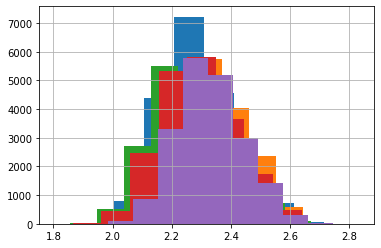

In [34]:
means_vr = []
for table in tables :
    means_vr.append(table.mean(axis=1))
    table.mean(axis=1).hist()

In [35]:
for ix, table in enumerate(tables) :
    table['mean'] = pd.Series(means_vr[ix])

In [56]:
tables[0]

,1_1,1_2,1_3,2_1,2_1.1,2_1.2,2_2,2_2.1,2_2.2,3_1,...,8_4,8_5,9_1,9_2,9_3,10_1,10_2,10_3,10_4,mean
1,3.000000,2.000000,3.000000,NaN,NaN,NaN,2.0,2.0,NaN,2.0,...,2.0,3.0,2.0,NaN,1.5,3.000000,2.666667,3.000000,NaN,2.364583
2,2.333333,2.000000,2.666667,NaN,NaN,NaN,2.0,2.0,NaN,2.0,...,1.5,3.0,2.0,NaN,2.0,3.000000,2.333333,2.666667,NaN,2.236979
3,2.333333,2.000000,2.333333,NaN,NaN,NaN,1.5,2.0,NaN,2.0,...,2.5,2.0,2.0,NaN,2.0,2.333333,2.000000,2.333333,NaN,2.190104
4,2.333333,2.000000,3.000000,NaN,NaN,NaN,2.0,2.0,NaN,1.5,...,2.0,2.5,2.0,NaN,1.5,2.666667,1.666667,3.000000,NaN,2.205729
5,2.666667,1.333333,2.000000,NaN,NaN,NaN,2.0,2.0,NaN,2.0,...,2.5,3.0,2.0,NaN,2.0,2.666667,2.666667,2.666667,NaN,2.338542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20021,3.000000,2.666667,2.666667,3.0,NaN,3.0,NaN,NaN,NaN,3.0,...,2.0,2.5,2.0,NaN,1.5,1.666667,2.666667,NaN,NaN,2.288889
20022,2.666667,1.666667,3.000000,3.0,NaN,3.0,NaN,NaN,NaN,2.0,...,3.0,2.0,2.0,NaN,1.5,2.000000,1.333333,NaN,NaN,2.252778
20023,2.666667,2.666667,2.333333,2.5,NaN,3.0,NaN,NaN,NaN,3.0,...,3.0,2.0,2.5,NaN,2.0,1.333333,2.666667,NaN,NaN,2.305556
20024,2.666667,1.666667,3.000000,2.5,NaN,3.0,NaN,NaN,NaN,3.0,...,3.0,2.0,3.0,NaN,1.5,1.000000,2.666667,NaN,NaN,2.272222


<img src='./imgs/self-confidence.jpg' />

In [56]:
def rank_value(x, means=[2.28, 2.52, 2.70], stds=[0.17, 0.11, 0.10]) :
    pdf_probs = []
    for i in range(len(means)) :
        pdf_probs.append(scipy.stats.norm.pdf(x, loc=means[i], scale=stds[i]))
    return np.argmax(pdf_probs) + 1

<AxesSubplot:>

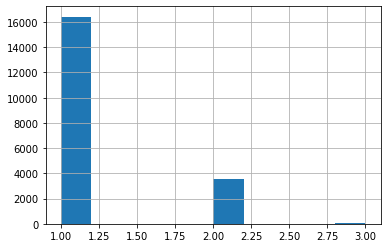

In [57]:
tables[0]['feedback'] = tables[0]['mean'].apply(rank_value)
tables[0]['feedback'].hist()

In [58]:
def rank_value(x, means=[2.49, 2.58, 2.76], stds=[0.06, 0.11, 0.11]) :
    pdf_probs = []
    for i in range(len(means)) :
        pdf_probs.append(scipy.stats.norm.pdf(x, loc=means[i], scale=stds[i]))
    return np.argmax(pdf_probs) + 1

<img src='./imgs/self-control.jpg' />

<AxesSubplot:>

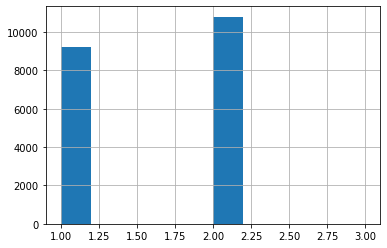

In [59]:
tables[1]['feedback'] = tables[1]['mean'].apply(rank_value)
tables[1]['feedback'].hist()

<img src='./imgs/openness-to-change.jpg' />

In [60]:
def rank_value(x, means=[2.33, 2.47, 2.66], stds=[0.09, 0.15, 0.13]) :
    pdf_probs = []
    for i in range(len(means)) :
        pdf_probs.append(scipy.stats.norm.pdf(x, loc=means[i], scale=stds[i]))
    return np.argmax(pdf_probs) + 1

<AxesSubplot:>

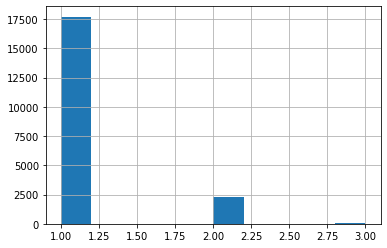

In [61]:
tables[2]['feedback'] = tables[2]['mean'].apply(rank_value)
tables[2]['feedback'].hist()

<img src='./imgs/responsibility.jpg' />

In [62]:
def rank_value(x, means=[2.36, 2.55, 2.76], stds=[0.10, 0.09, 0.21]) :
    pdf_probs = []
    for i in range(len(means)) :
        pdf_probs.append(scipy.stats.norm.pdf(x, loc=means[i], scale=stds[i]))
    return np.argmax(pdf_probs) + 1

<AxesSubplot:>

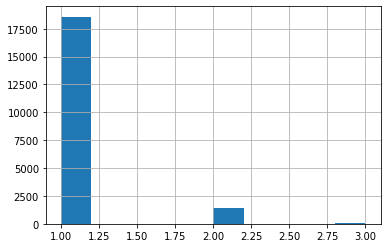

In [63]:
tables[3]['feedback'] = tables[3]['mean'].apply(rank_value)
tables[3]['feedback'].hist()

<img src='./imgs/communicability.jpg' />

In [64]:
def rank_value(x, means=[2.51, 2.57, 2.73], stds=[0.10, 0.10, 0.07]) :
    pdf_probs = []
    for i in range(len(means)) :
        pdf_probs.append(scipy.stats.norm.pdf(x, loc=means[i], scale=stds[i]))
    return np.argmax(pdf_probs) + 1

<AxesSubplot:>

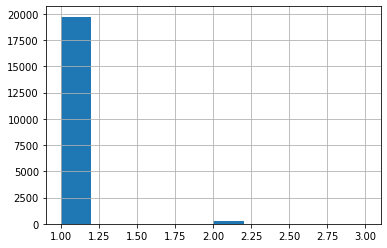

In [65]:
tables[4]['feedback'] = tables[4]['mean'].apply(rank_value)
tables[4]['feedback'].hist()

## Fusion of data and additional features

In [90]:
new_df['id'].copy()

0             1
1           1_1
2           1_2
3           1_3
4           1_4
          ...  
20045    50_396
20046    50_397
20047    50_398
20048    50_399
20049    50_400
Name: id, Length: 20050, dtype: object

In [121]:
tables[4]

,1_1,1_2,1_3,2_1,2_1.1,2_1.2,2_2,2_2.1,2_2.2,3_1,...,9_2,9_3,10_1,10_2,10_3,10_4,mean,feedback,id,M061
1,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.00,...,NaN,1.8,2.4,2.0,NaN,NaN,2.585214,2,1,1
2,2.4,2.0,2.8,NaN,NaN,NaN,NaN,NaN,NaN,2.50,...,NaN,2.0,2.2,2.0,NaN,NaN,2.314879,1,1_1,1
3,3.0,3.0,2.2,NaN,NaN,NaN,NaN,NaN,NaN,3.00,...,NaN,1.4,2.2,1.6,NaN,NaN,2.402538,1,1_2,1
4,2.6,2.6,2.6,NaN,NaN,NaN,NaN,NaN,NaN,2.50,...,NaN,2.2,2.6,2.0,NaN,NaN,2.442046,1,1_3,1
5,2.6,2.6,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.75,...,NaN,2.0,2.2,2.2,NaN,NaN,2.337720,1,1_4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20046,3.0,2.4,2.6,NaN,NaN,NaN,NaN,NaN,NaN,2.50,...,NaN,2.0,1.8,1.8,NaN,NaN,2.217911,1,50_396,4
20047,3.0,2.8,2.6,NaN,NaN,NaN,NaN,NaN,NaN,2.25,...,NaN,1.8,1.8,2.0,NaN,NaN,2.235173,1,50_397,4
20048,3.0,2.4,2.6,NaN,NaN,NaN,NaN,NaN,NaN,2.75,...,NaN,1.8,1.2,1.8,NaN,NaN,2.230411,1,50_398,2
20049,2.6,2.8,2.8,NaN,NaN,NaN,NaN,NaN,NaN,3.00,...,NaN,1.8,1.4,2.2,NaN,NaN,2.283390,1,50_399,3


In [122]:
tables[4]['M061'] = tables[4]['M061'].astype(int)

In [123]:
tables[4][['mean', 'feedback', 'M061']].corr()

,mean,feedback,M061
mean,1.000000,0.292331,0.005909
feedback,0.292331,1.000000,0.077149
M061,0.005909,0.077149,1.000000


In [92]:
some

0

In [125]:
some = new_df['id'].copy()
some.index = tables[0]['feedback'].index
#print(tables[0]['feedback'])
#print(some)
some1 = new_df['M061'].copy()
some1.index = tables[0]['feedback'].index
for table in tables :  
    table['id'] = some
    table['M061'] = some1

In [126]:
tables[4].head()

,1_1,1_2,1_3,2_1,2_1.1,2_1.2,2_2,2_2.1,2_2.2,3_1,...,9_2,9_3,10_1,10_2,10_3,10_4,mean,feedback,id,M061
1,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.00,...,NaN,1.8,2.4,2.0,NaN,NaN,2.585214,2,1,1
2,2.4,2.0,2.8,NaN,NaN,NaN,NaN,NaN,NaN,2.50,...,NaN,2.0,2.2,2.0,NaN,NaN,2.314879,1,1_1,1
3,3.0,3.0,2.2,NaN,NaN,NaN,NaN,NaN,NaN,3.00,...,NaN,1.4,2.2,1.6,NaN,NaN,2.402538,1,1_2,1
4,2.6,2.6,2.6,NaN,NaN,NaN,NaN,NaN,NaN,2.50,...,NaN,2.2,2.6,2.0,NaN,NaN,2.442046,1,1_3,0
5,2.6,2.6,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.75,...,NaN,2.0,2.2,2.2,NaN,NaN,2.337720,1,1_4,1


In [127]:
tables[0][tables[0]['M061'] == 1]['mean'].mean()

2.233677607938277

In [128]:
tables[0][tables[0]['M061'] == 2]['mean'].mean()

2.290738878149184

In [130]:
for ix, comp in enumerate(competences) :
    tables[ix].to_csv('./data/' + comp + '.csv')

In [103]:
tables[0]['M061'].describe()

count     20050
unique        7
top           2
freq       7925
Name: M061, dtype: int64

In [36]:
means = []
for table in tables :
    means.append(table['mean'])
total_mean = pd.concat(means, axis=1, ignore_index=True)
for table in tables :
    table['total_mean'] = total_mean.mean(axis=1)


In [37]:
tables[0].head()

,1_1_vr,1_2_vr,1_3_vr,2_1_vr,2_1.1_vr,2_1.2_vr,2_2_vr,2_2.1_vr,2_2.2_vr,3_1_vr,...,8_5_vr,9_1_vr,9_2_vr,9_3_vr,10_1_vr,10_2_vr,10_3_vr,10_4_vr,mean,total_mean
1,3.000000,2.000000,3.000000,NaN,NaN,NaN,2.0,2.0,NaN,2.0,...,3.0,2.0,NaN,1.5,3.000000,2.666667,3.000000,NaN,2.364583,2.391058
2,2.333333,2.000000,2.666667,NaN,NaN,NaN,2.0,2.0,NaN,2.0,...,3.0,2.0,NaN,2.0,3.000000,2.333333,2.666667,NaN,2.236979,2.283078
3,2.333333,2.000000,2.333333,NaN,NaN,NaN,1.5,2.0,NaN,2.0,...,2.0,2.0,NaN,2.0,2.333333,2.000000,2.333333,NaN,2.190104,2.278074
4,2.333333,2.000000,3.000000,NaN,NaN,NaN,2.0,2.0,NaN,1.5,...,2.5,2.0,NaN,1.5,2.666667,1.666667,3.000000,NaN,2.205729,2.273335
5,2.666667,1.333333,2.000000,NaN,NaN,NaN,2.0,2.0,NaN,2.0,...,3.0,2.0,NaN,2.0,2.666667,2.666667,2.666667,NaN,2.338542,2.302062


In [129]:
means = []
stds = []
mins = []
maxs = []
original_means = []
calculated_means = []

for table in tables :
    
    total_mean = table['mean'].mean()
    partial_mean = 0
    mean_pack = []
    std_pack = []
    min_pack = []
    max_pack = []
    #print(table['mean'].mean())
    mean_pack.append(table[table['M061'].isin([3, 4])]['mean'].mean())
    std_pack.append(table[table['M061'].isin([3, 4])]['mean'].std())
    min_pack.append(table[table['M061'].isin([3, 4])]['mean'].min())
    max_pack.append(table[table['M061'].isin([3, 4])]['mean'].max())
    
    print(table[table['M061'].isin([3, 4])].shape[0])
    partial_mean += mean_pack[-1] * table[table['M061'].isin([3, 4])].shape[0]
    
    mean_pack.append(table[table['M061'] == 2]['mean'].mean())
    std_pack.append(table[table['M061'] == 2]['mean'].std())
    min_pack.append(table[table['M061'] == 2]['mean'].min())
    max_pack.append(table[table['M061'] == 2]['mean'].max())
    
    print(table[table['M061'] == 2].shape[0])
    partial_mean += mean_pack[-1] * table[table['M061'] == 2].shape[0]   
    
    mean_pack.append(table[table['M061'].isin([0, 1])]['mean'].mean())
    std_pack.append(table[table['M061'].isin([0, 1])]['mean'].std())
    min_pack.append(table[table['M061'].isin([0, 1])]['mean'].min())
    max_pack.append(table[table['M061'].isin([0, 1])]['mean'].max())
    #print(table[table['M061'] == 1]['mean'].mean())
    
    print(table[table['M061'].isin([0, 1])].shape[0])
    partial_mean += mean_pack[-1] * table[table['M061'].isin([0, 1])].shape[0]   
    
    #print(table[table['M061'] == 2]['mean'].mean())
   
    partial_mean /= table.shape[0]
    #print(table[table['M061'].isin([3, 4])]['mean'].mean())
    print(mean_pack)
    print('Original mean', total_mean) 
    print('Caclulated mean', partial_mean)
    print('Original elements', table.shape[0])
    print('Calculated elements', table[table['M061'].isin([3, 4])].shape[0] + table[table['M061'] == 2].shape[0] + table[table['M061'].isin([0, 1])].shape[0])
    means.append(mean_pack)
    stds.append(std_pack)
    mins.append(min_pack)
    maxs.append(max_pack)
    

9152
5218
5680
[2.2631355078945545, 2.290738878149184, 2.220964964859755]
Original mean 2.2583726999918605
Caclulated mean 2.258372699991861
Original elements 20050
Calculated elements 20050
9152
5218
5680
[2.3198580468068504, 2.330123122391954, 2.2925686755877783]
Original mean 2.3147986720377105
Caclulated mean 2.31479867203771
Original elements 20050
Calculated elements 20050
9152
5218
5680
[2.229172787717509, 2.232295352142521, 2.187181717209783]
Original mean 2.2180897084499693
Caclulated mean 2.2180897084499693
Original elements 20050
Calculated elements 20050
9152
5218
5680
[2.26371386622512, 2.280371941420013, 2.2278918237091485]
Original mean 2.257901030059346
Caclulated mean 2.2579010300593465
Original elements 20050
Calculated elements 20050
9152
5218
5680
[2.2923954725850044, 2.2951148834767814, 2.260558102011285]
Original mean 2.28408393249396
Caclulated mean 2.2840839324939606
Original elements 20050
Calculated elements 20050


In [104]:
means = []
stds = []
mins = []
maxs = []
original_means = []
calculated_means = []

for table in tables :
    
    total_mean = table['mean'].mean()
    partial_mean = 0
    mean_pack = []
    std_pack = []
    min_pack = []
    max_pack = []
    #print(table['mean'].mean())
    mean_pack.append(table[table['M061'].isin([3, 4, 5, 6])]['mean'].mean())
    std_pack.append(table[table['M061'].isin([3, 4, 5, 6])]['mean'].std())
    min_pack.append(table[table['M061'].isin([3, 4, 5, 6])]['mean'].min())
    max_pack.append(table[table['M061'].isin([3, 4, 5, 6])]['mean'].max())
    
    print(table[table['M061'].isin([3, 4, 5, 6])].shape[0])
    partial_mean += mean_pack[-1] * table[table['M061'].isin([3, 4, 5, 6])].shape[0]
    
    mean_pack.append(table[table['M061'] == 2]['mean'].mean())
    std_pack.append(table[table['M061'] == 2]['mean'].std())
    min_pack.append(table[table['M061'] == 2]['mean'].min())
    max_pack.append(table[table['M061'] == 2]['mean'].max())
    
    print(table[table['M061'] == 2].shape[0])
    partial_mean += mean_pack[-1] * table[table['M061'] == 2].shape[0]   
    
    mean_pack.append(table[table['M061'].isin([0, 1])]['mean'].mean())
    std_pack.append(table[table['M061'].isin([0, 1])]['mean'].std())
    min_pack.append(table[table['M061'].isin([0, 1])]['mean'].min())
    max_pack.append(table[table['M061'].isin([0, 1])]['mean'].max())
    #print(table[table['M061'] == 1]['mean'].mean())
    
    print(table[table['M061'].isin([0, 1])].shape[0])
    partial_mean += mean_pack[-1] * table[table['M061'].isin([0, 1])].shape[0]   
    
    #print(table[table['M061'] == 2]['mean'].mean())
   
    partial_mean /= table.shape[0]
    #print(table[table['M061'].isin([3, 4])]['mean'].mean())
    print(mean_pack)
    print('Original mean', total_mean) 
    print('Caclulated mean', partial_mean)
    print('Original elements', table.shape[0])
    print('Calculated elements', table[table['M061'].isin([3, 4, 5, 6])].shape[0] + table[table['M061'] == 2].shape[0] + table[table['M061'].isin([0, 1])].shape[0])
    means.append(mean_pack)
    stds.append(std_pack)
    mins.append(min_pack)
    maxs.append(max_pack)
    

9282
7925
2843
[2.29434419472371, 2.29308306628887, 2.2928469569539454]
Original mean 2.2936334171763013
Caclulated mean 2.293633417176301
Original elements 20050
Calculated elements 20050
9282
7925
2843
[2.3378766715901347, 2.328913616505331, 2.3523349615296083]
Original mean 2.336384038510377
Caclulated mean 2.336384038510377
Original elements 20050
Calculated elements 20050
9282
7925
2843
[2.265171809588518, 2.254414408071698, 2.2591988318195964]
Original mean 2.260072877777154
Caclulated mean 2.260072877777154
Original elements 20050
Calculated elements 20050
9282
7925
2843
[2.297083832760164, 2.2918953251234604, 2.3054057234308565]
Original mean 2.296213020398863
Caclulated mean 2.2962130203988624
Original elements 20050
Calculated elements 20050
9282
7925
2843
[2.334278962753876, 2.318989038283894, 2.343025640518823]
Original mean 2.3294756786372246
Caclulated mean 2.329475678637224
Original elements 20050
Calculated elements 20050


In [130]:
index = ['Трансформационные руководители', 'Трансакционные руководители', 'Не руководители']

In [131]:
means = list(map(lambda x : pd.Series(x, index=index ), means))
stds = list(map(lambda x : pd.Series(x, index=index ), stds))
mins = list(map(lambda x : pd.Series(x, index=index ), mins))
maxs = list(map(lambda x : pd.Series(x, index=index ), maxs))

In [132]:
comp_dfs = []
for i in range(5) :
    comp_dfs.append(pd.concat([mins[i], maxs[i], means[i], stds[i]], axis=1, keys=['min' , 'max', 'mean', 'std']))

In [133]:
print('Подход № 1 - определение типа руководителя по сгенерированным доп характеристике опыта управления')
for ix, competence in enumerate(competences) :
    print(competence)
    print(comp_dfs[ix])
    print('\n')
    print('--------------------')

Подход № 1 - определение типа руководителя по сгенерированным доп характеристике опыта управления
Self-confidence
                                     min       max      mean       std
Трансформационные руководители  1.953153  2.822216  2.263136  0.114243
Трансакционные руководители     1.972249  2.757569  2.290739  0.103473
Не руководители                 1.816696  2.666658  2.220965  0.113939


--------------------
Self-control
                                     min       max      mean       std
Трансформационные руководители  1.913576  2.833942  2.319858  0.096069
Трансакционные руководители     2.083336  2.595577  2.330123  0.067192
Не руководители                 1.929329  2.709668  2.292569  0.098673


--------------------
Openness to change
                                     min       max      mean       std
Трансформационные руководители  1.889993  2.772423  2.229173  0.114608
Трансакционные руководители     1.926662  2.669980  2.232295  0.094242
Не руководители            

In [134]:
means = []
stds = []
mins = []
maxs = []
for table in tables :
    total_mean = table['mean'].mean()
    partial_mean = 0
    
    mean_pack = []
    std_pack = []
    min_pack = []
    max_pack = []
    
    
    
    mean_pack.append(table[table['feedback'] == 3]['mean'].mean())
    std_pack.append(table[table['feedback'] == 3]['mean'].std())
    min_pack.append(table[table['feedback'] == 3]['mean'].min())
    max_pack.append(table[table['feedback'] == 3]['mean'].max())
    
    print(table[table['feedback'] == 3].shape[0])
    partial_mean += mean_pack[-1] * table[table['feedback'] == 3].shape[0]
    
    mean_pack.append(table[table['feedback'] == 2]['mean'].mean())
    std_pack.append(table[table['feedback'] == 2]['mean'].std())
    min_pack.append(table[table['feedback'] == 2]['mean'].min())
    max_pack.append(table[table['feedback'] == 2]['mean'].max())
    
    print(table[table['feedback'] == 2].shape[0])
    partial_mean += mean_pack[-1] * table[table['feedback'] == 2].shape[0]
    
    mean_pack.append(table[table['feedback'] == 1]['mean'].mean())
    std_pack.append(table[table['feedback'] == 1]['mean'].std())
    min_pack.append(table[table['feedback'] == 1]['mean'].min())
    max_pack.append(table[table['feedback'] == 1]['mean'].max())
    
    print(table[table['feedback'] == 1].shape[0])
    partial_mean += mean_pack[-1] * table[table['feedback'] == 1].shape[0]
    
    
    partial_mean /= table.shape[0]
    #print(table[table['M061'].isin([3, 4])]['mean'].mean())
    print(mean_pack)
    print('Total mean', total_mean) 
    print('Partial mean', partial_mean)
    print('Total elements', table.shape[0])
    print('Partial elements', table[table['feedback'] == 3].shape[0] + table[table['feedback'] == 2].shape[0] + table[table['feedback'] == 1].shape[0])
    
    means.append(mean_pack)
    stds.append(std_pack)
    mins.append(min_pack)
    maxs.append(max_pack)

42
3061
16947
[2.6575929768673348, 2.4473586088364883, 2.223248305196194]
Total mean 2.2583726999918605
Partial mean 2.2583726999918614
Total elements 20050
Partial elements 20050
11
11915
8124
[2.717571488144172, 2.263035309497727, 2.3901716365486325]
Total mean 2.3147986720377105
Partial mean 2.3147986720377105
Total elements 20050
Partial elements 20050
64
2089
17897
[2.606650259968572, 2.2427581533914562, 2.213820822224348]
Total mean 2.2180897084499693
Partial mean 2.2180897084499698
Total elements 20050
Partial elements 20050
32
1092
18926
[2.0469939720078063, 2.499057452989145, 2.2443432900201574]
Total mean 2.257901030059346
Partial mean 2.2579010300593465
Total elements 20050
Partial elements 20050
7
185
19858
[2.692080457376117, 2.5694382228973494, 2.281281710749635]
Total mean 2.28408393249396
Partial mean 2.2840839324939597
Total elements 20050
Partial elements 20050


In [135]:
index = ['Трансформационные руководители', 'Трансакционные руководители', 'Не руководители']

In [136]:
means = list(map(lambda x : pd.Series(x, index=index ), means))
stds = list(map(lambda x : pd.Series(x, index=index ), stds))
mins = list(map(lambda x : pd.Series(x, index=index ), mins))
maxs = list(map(lambda x : pd.Series(x, index=index ), maxs))

In [137]:
comp_dfs = []
for i in range(5) :
    comp_dfs.append(pd.concat([mins[i], maxs[i], means[i], stds[i]], axis=1, keys=['min' , 'max', 'mean', 'std']))

In [138]:
print('Подход № 2 - определение типа руководителя по среднему арифметическому и статистикам в отчете')
for ix, competence in enumerate(competences) :
    print(competence)
    print(comp_dfs[ix])
    print('\n')
    print('--------------------')

Подход № 2 - определение типа руководителя по среднему арифметическому и статистикам в отчете
Self-confidence
                                     min       max      mean       std
Трансформационные руководители  2.622209  2.822216  2.657593  0.042770
Трансакционные руководители     2.393950  2.588400  2.447359  0.042428
Не руководители                 1.816696  2.393694  2.223248  0.084195


--------------------
Self-control
                                     min       max      mean       std
Трансформационные руководители  2.685170  2.833942  2.717571  0.043625
Трансакционные руководители     1.913576  2.641389  2.263035  0.079230
Не руководители                 2.346604  2.557007  2.390172  0.039849


--------------------
Openness to change
                                     min       max      mean       std
Трансформационные руководители  2.574696  2.772423  2.606650  0.036762
Трансакционные руководители     1.876537  2.535286  2.242758  0.212995
Не руководители                

In [267]:
means = []
stds = []
mins = []
maxs = []
original_means = []
calculated_means = []

for table in tables :
    
    total_mean = table['mean'].mean()
    partial_mean = 0
    mean_pack = []
    std_pack = []
    min_pack = []
    max_pack = []
    #print(table['mean'].mean())
    mean_pack.append(table[table['total_mean'].between(2.63, 3.00)]['mean'].mean())
    std_pack.append(table[table['total_mean'].between(2.63, 3.00)]['mean'].std())
    min_pack.append(table[table['total_mean'].between(2.63, 3.00)]['mean'].min())
    max_pack.append(table[table['total_mean'].between(2.63, 3.00)]['mean'].max())
    
    print(table[table['total_mean'].between(2.63, 3.00)].shape[0])
    partial_mean += mean_pack[-1] * table[table['total_mean'].between(2.63, 3.00)].shape[0]
    
    mean_pack.append(table[table['total_mean'].between(2.46, 2.63)]['mean'].mean())
    std_pack.append(table[table['total_mean'].between(2.46, 2.63)]['mean'].std())
    min_pack.append(table[table['total_mean'].between(2.46, 2.63)]['mean'].min())
    max_pack.append(table[table['total_mean'].between(2.46, 2.63)]['mean'].max())
    
    print(table[table['total_mean'].between(2.46, 2.63)].shape[0])
    partial_mean += mean_pack[-1] * table[table['total_mean'].between(2.46, 2.63)].shape[0]   
    
    mean_pack.append(table[table['total_mean'] < 2.46]['mean'].mean())
    std_pack.append(table[table['total_mean'] < 2.46]['mean'].std())
    min_pack.append(table[table['total_mean'] < 2.46]['mean'].min())
    max_pack.append(table[table['total_mean'] < 2.46]['mean'].max())
    #print(table[table['M061'] == 1]['mean'].mean())
    
    print(table[table['total_mean'] < 2.46].shape[0])
    partial_mean += mean_pack[-1] * table[table['total_mean'] < 2.46].shape[0]   
    
    #print(table[table['M061'] == 2]['mean'].mean())
   
    partial_mean /= table.shape[0]
    #print(table[table['M061'].isin([3, 4])]['mean'].mean())
    print(mean_pack)
    print('Original mean', total_mean) 
    print('Caclulated mean', partial_mean)
    print('Original elements', table.shape[0])
    print('Calculated elements', table[table['total_mean'].between(2.63, 3.00)].shape[0] + table[table['total_mean'].between(2.46, 2.63)].shape[0] + table[table['total_mean'] < 2.46].shape[0])
    means.append(mean_pack)
    stds.append(std_pack)
    mins.append(min_pack)
    maxs.append(max_pack)
    

4
279
19767
[2.732911414934019, 2.500264968980641, 2.254862501281503]
Original mean 2.2583726999918605
Caclulated mean 2.2583726999918605
Original elements 20050
Calculated elements 20050
4
279
19767
[2.7195001720013927, 2.498570611489945, 2.3121229409147768]
Original mean 2.3147986720377105
Caclulated mean 2.3147986720377105
Original elements 20050
Calculated elements 20050
4
279
19767
[2.6706067182146205, 2.4616559303978374, 2.2145603390989037]
Original mean 2.2180897084499693
Caclulated mean 2.2180897084499693
Original elements 20050
Calculated elements 20050
4
279
19767
[2.727724721277986, 2.4992264464437626, 2.2543997862724225]
Original mean 2.257901030059346
Caclulated mean 2.2579010300593465
Original elements 20050
Calculated elements 20050
4
279
19767
[2.6301858809554473, 2.4910418000877006, 2.2810928031950026]
Original mean 2.28408393249396
Caclulated mean 2.28408393249396
Original elements 20050
Calculated elements 20050


In [38]:
means = []
stds = []
mins = []
maxs = []
original_means = []
calculated_means = []

for table in tables :
    
    total_mean = table['mean'].mean()
    partial_mean = 0
    mean_pack = []
    std_pack = []
    min_pack = []
    max_pack = []
    #print(table['mean'].mean())
    mean_pack.append(table[table['total_mean'].between(2.40, 3.00)]['mean'].mean())
    std_pack.append(table[table['total_mean'].between(2.40, 3.00)]['mean'].std())
    min_pack.append(table[table['total_mean'].between(2.40, 3.00)]['mean'].min())
    max_pack.append(table[table['total_mean'].between(2.40, 3.00)]['mean'].max())
    
    print(table[table['total_mean'].between(2.40, 3.00)].shape[0])
    partial_mean += mean_pack[-1] * table[table['total_mean'].between(2.40, 3.00)].shape[0]
    
    mean_pack.append(table[table['total_mean'].between(2.20, 2.40)]['mean'].mean())
    std_pack.append(table[table['total_mean'].between(2.20, 2.40)]['mean'].std())
    min_pack.append(table[table['total_mean'].between(2.20, 2.40)]['mean'].min())
    max_pack.append(table[table['total_mean'].between(2.20, 2.40)]['mean'].max())
    
    print(table[table['total_mean'].between(2.20, 2.40)].shape[0])
    partial_mean += mean_pack[-1] * table[table['total_mean'].between(2.20, 2.40)].shape[0]   
    
    mean_pack.append(table[table['total_mean'] < 2.20]['mean'].mean())
    std_pack.append(table[table['total_mean'] < 2.20]['mean'].std())
    min_pack.append(table[table['total_mean'] < 2.20]['mean'].min())
    max_pack.append(table[table['total_mean'] < 2.20]['mean'].max())
    #print(table[table['M061'] == 1]['mean'].mean())
    
    print(table[table['total_mean'] < 2.20].shape[0])
    partial_mean += mean_pack[-1] * table[table['total_mean'] < 2.20].shape[0]   
    
    #print(table[table['M061'] == 2]['mean'].mean())
   
    partial_mean /= table.shape[0]
    #print(table[table['M061'].isin([3, 4])]['mean'].mean())
    print(mean_pack)
    print('Original mean', total_mean) 
    print('Caclulated mean', partial_mean)
    print('Original elements', table.shape[0])
    print('Calculated elements', table[table['total_mean'].between(2.40, 3.00)].shape[0] + table[table['total_mean'].between(2.20, 2.40)].shape[0] + table[table['total_mean'] < 2.20].shape[0])
    means.append(mean_pack)
    stds.append(std_pack)
    mins.append(min_pack)
    maxs.append(max_pack)
    

3340
14069
2602
[2.4552932739725564, 2.266723894920087, 2.1813824383879403]
Original mean 2.287098123474153
Caclulated mean 2.2872151482950756
Original elements 20010
Calculated elements 20011
3340
14069
2602
[2.4922011721117245, 2.317016791165113, 2.1837038939663347]
Original mean 2.3289129647898696
Caclulated mean 2.3290384148853343
Original elements 20010
Calculated elements 20011
3340
14069
2602
[2.4268545519177516, 2.2375722887778378, 2.119914129353343]
Original mean 2.2538666521266615
Caclulated mean 2.253978775552128
Original elements 20010
Calculated elements 20011
3340
14069
2602
[2.4563909377137016, 2.273359540844763, 2.1356899912253797]
Original mean 2.2859985741767703
Caclulated mean 2.2861222623326922
Original elements 20010
Calculated elements 20011
3340
14069
2602
[2.484462929991248, 2.3166208551394925, 2.1973368837194185]
Original mean 2.3291197441972376
Caclulated mean 2.3292411578493857
Original elements 20010
Calculated elements 20011


In [39]:
index = ['Трансформационные руководители', 'Трансакционные руководители', 'Не руководители']

In [40]:
means = list(map(lambda x : pd.Series(x, index=index ), means))
stds = list(map(lambda x : pd.Series(x, index=index ), stds))
mins = list(map(lambda x : pd.Series(x, index=index ), mins))
maxs = list(map(lambda x : pd.Series(x, index=index ), maxs))

In [41]:
comp_dfs = []
for i in range(5) :
    comp_dfs.append(pd.concat([mins[i], maxs[i], means[i], stds[i]], axis=1, keys=['min' , 'max', 'mean', 'std']))

In [42]:
print('Подход № 3 - определение типа руководителя по ГЛОБАЛЬНОМУ среднему арифметическому и статистикам в отчете')
for ix, competence in enumerate(competences) :
    print(competence)
    print(comp_dfs[ix])
    print('\n')
    print('--------------------')

Подход № 3 - определение типа руководителя по ГЛОБАЛЬНОМУ среднему арифметическому и статистикам в отчете
Self-confidence
                                     min       max      mean       std
Трансформационные руководители  2.197917  2.816092  2.455293  0.080123
Трансакционные руководители     1.947917  2.600000  2.266724  0.084825
Не руководители                 1.803763  2.446429  2.181382  0.074390


--------------------
Self-control
                                     min       max      mean       std
Трансформационные руководители  2.251111  2.827564  2.492201  0.067466
Трансакционные руководители     2.036782  2.611538  2.317017  0.086653
Не руководители                 1.913462  2.449425  2.183704  0.078974


--------------------
Openness to change
                                     min       max      mean       std
Трансформационные руководители  2.073718  2.763333  2.426855  0.082845
Трансакционные руководители     1.907051  2.594697  2.237572  0.097422
Не руководители    

In [51]:
for ix, comp in enumerate(competences) :
    tables[ix].to_csv('./data/' + comp + '.csv')

In [48]:
def rank_value(x, means=[2.51, 2.57, 2.73], stds=[0.10, 0.10, 0.07]) :
    pdf_probs = []
    for i in range(len(means)) :
        pdf_probs.append(scipy.stats.norm.pdf(x, loc=means[i], scale=stds[i]))
    return np.argmax(pdf_probs) + 1

In [69]:
for ix, table in enumerate(tables) :
    table['new_feedback'] = table['mean'].apply(rank_value, args = (means[ix].tolist()[::-1], stds[ix].tolist()[::-1]))

In [43]:
for ix, table in enumerate(tables) :
    table['new_feedback'] = 0
    table.loc[table['total_mean'].between(2.40, 3.00), 'new_feedback'] = 3
    table.loc[table['total_mean'].between(2.20, 2.40), 'new_feedback'] = 2
    table.loc[table['total_mean'] < 2.20, 'new_feedback'] = 1

In [44]:
tables[0]

,1_1_vr,1_2_vr,1_3_vr,2_1_vr,2_1.1_vr,2_1.2_vr,2_2_vr,2_2.1_vr,2_2.2_vr,3_1_vr,...,9_1_vr,9_2_vr,9_3_vr,10_1_vr,10_2_vr,10_3_vr,10_4_vr,mean,total_mean,new_feedback
1,3.000000,2.000000,3.000000,NaN,NaN,NaN,2.0,2.0,NaN,2.0,...,2.0,NaN,1.5,3.000000,2.666667,3.000000,NaN,2.364583,2.391058,2
2,2.333333,2.000000,2.666667,NaN,NaN,NaN,2.0,2.0,NaN,2.0,...,2.0,NaN,2.0,3.000000,2.333333,2.666667,NaN,2.236979,2.283078,2
3,2.333333,2.000000,2.333333,NaN,NaN,NaN,1.5,2.0,NaN,2.0,...,2.0,NaN,2.0,2.333333,2.000000,2.333333,NaN,2.190104,2.278074,2
4,2.333333,2.000000,3.000000,NaN,NaN,NaN,2.0,2.0,NaN,1.5,...,2.0,NaN,1.5,2.666667,1.666667,3.000000,NaN,2.205729,2.273335,2
5,2.666667,1.333333,2.000000,NaN,NaN,NaN,2.0,2.0,NaN,2.0,...,2.0,NaN,2.0,2.666667,2.666667,2.666667,NaN,2.338542,2.302062,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20006,3.000000,2.333333,3.000000,3.0,NaN,3.0,NaN,NaN,NaN,3.0,...,2.5,NaN,1.5,1.666667,3.000000,NaN,NaN,2.380556,2.267593,2
20007,3.000000,3.000000,2.000000,2.5,NaN,2.5,NaN,NaN,NaN,2.5,...,3.0,NaN,1.5,1.000000,1.666667,NaN,NaN,2.036111,2.173704,1
20008,3.000000,2.333333,3.000000,2.0,NaN,2.0,NaN,NaN,NaN,3.0,...,2.5,NaN,1.5,2.000000,2.000000,NaN,NaN,2.161111,2.217654,2
20009,2.333333,2.333333,2.333333,3.0,NaN,2.5,NaN,NaN,NaN,3.0,...,3.0,NaN,2.5,1.666667,2.666667,NaN,NaN,2.283333,2.263179,2


In [45]:
for idx, comp in enumerate(competences) :
    print(comp)
    print(tables[idx]['new_feedback'].value_counts())

Self-confidence
2    14069
3     3339
1     2602
Name: new_feedback, dtype: int64
Self-control
2    14069
3     3339
1     2602
Name: new_feedback, dtype: int64
Openness to change
2    14069
3     3339
1     2602
Name: new_feedback, dtype: int64
Responsibility
2    14069
3     3339
1     2602
Name: new_feedback, dtype: int64
Communicability
2    14069
3     3339
1     2602
Name: new_feedback, dtype: int64


In [ ]:
trunc_tables = []
for table in tables :
    trunc_tables.append(table['new_feedback'])

## Learning

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

In [40]:
tables = []
for ix, comp in enumerate(competences) :
    tables.append(pd.read_csv('./data/' + comp + '.csv', index_col=0))

In [67]:
tables[0].head()

,1_1,1_2,1_3,2_1,2_1.1,2_1.2,2_2,2_2.1,2_2.2,3_1,...,9_1,9_2,9_3,10_1,10_2,10_3,10_4,mean,total_mean,new_feedback
1,3.000000,2.000000,3.000000,NaN,NaN,NaN,2.0,2.0,NaN,2.0,...,2.0,NaN,1.5,3.000000,2.666667,3.000000,NaN,2.364583,2.391058,2
2,2.333333,2.000000,2.666667,NaN,NaN,NaN,2.0,2.0,NaN,2.0,...,2.0,NaN,2.0,3.000000,2.333333,2.666667,NaN,2.236979,2.283078,2
3,2.333333,2.000000,2.333333,NaN,NaN,NaN,1.5,2.0,NaN,2.0,...,2.0,NaN,2.0,2.333333,2.000000,2.333333,NaN,2.190104,2.278074,2
4,2.333333,2.000000,3.000000,NaN,NaN,NaN,2.0,2.0,NaN,1.5,...,2.0,NaN,1.5,2.666667,1.666667,3.000000,NaN,2.205729,2.273335,2
5,2.666667,1.333333,2.000000,NaN,NaN,NaN,2.0,2.0,NaN,2.0,...,2.0,NaN,2.0,2.666667,2.666667,2.666667,NaN,2.338542,2.302062,2


In [51]:
clfs = []
scalers = []
X_trains = []
y_trains = []
X_tests = []
y_tests = []
for i in range(5) :
    clfs.append(LogisticRegression(random_state=0))
    scalers.append(StandardScaler())
    y = tables[i]['new_feedback']
    #X = tables[i].drop(['new_feedback', 'M061', 'mean', 'id', 'total_mean', 'feedback'], axis=1)
    X = tables[i].drop(['new_feedback', 'mean', 'total_mean'], axis=1)
    X_drop = X.dropna(axis=1)

    X_drop.head()

    X_train, X_test, y_train, y_test = train_test_split(X_drop, y, test_size=0.20, stratify=y, random_state=42)
    scalers[i].fit(X_train)
    X_train = scalers[i].transform(X_train)
    X_test = scalers[i].transform(X_test)
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)
    print(len(X_trains[i]))
    print(len(X_tests[i]))

16040
4010
16040
4010
16040
4010
16040
4010
16040
4010


In [82]:
pd.set_option('display.max_columns', None)

In [93]:
pd.DataFrame(list(map(lambda x : x.split('_vr')[0], tables[3].columns))).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
0,1_1,1_2,1_3,2_1,2_1.1,2_1.2,2_2,2_2.1,2_2.2,3_1,3_2,3_3,3_4,3_5,3_6,3_7,4_1,4_2,4_3,4_4,5_1,5_2,5_3,5_4,5_5,5_6,6_1,6_2,6_3,6_4,6_5,6_6,7_1,7_2,7_3,7_4,7_5,8_1,8_2,8_3,8_4,8_5,9_1,9_2,9_3,10_1,10_2,10_3,10_4,mean,total_mean,new_feedback


In [95]:
tables[4].head(1)

,1_1_vr,1_2_vr,1_3_vr,2_1_vr,2_1.1_vr,2_1.2_vr,2_2_vr,2_2.1_vr,2_2.2_vr,3_1_vr,3_2_vr,3_3_vr,3_4_vr,3_5_vr,3_6_vr,3_7_vr,4_1_vr,4_2_vr,4_3_vr,4_4_vr,5_1_vr,5_2_vr,5_3_vr,5_4_vr,5_5_vr,5_6_vr,6_1_vr,6_2_vr,6_3_vr,6_4_vr,6_5_vr,6_6_vr,7_1_vr,7_2_vr,7_3_vr,7_4_vr,7_5_vr,8_1_vr,8_2_vr,8_3_vr,8_4_vr,8_5_vr,9_1_vr,9_2_vr,9_3_vr,10_1_vr,10_2_vr,10_3_vr,10_4_vr,mean,total_mean,new_feedback
1,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.8,3.0,NaN,3.0,NaN,NaN,3.0,NaN,2.0,2.0,NaN,1.0,NaN,NaN,NaN,3.0,3.0,3.0,3.0,3.0,0.0,3.0,3.0,3.0,3.0,2.8,NaN,1.8,2.4,2.0,NaN,NaN,2.607692,2.623745,3


In [61]:
set_size = [25, 50, 75, 100, 200, 400, 800, 1000, 5000, 10000, 15000]
np.random.seed(42)
acc_scores = [[] for i in range(5)]
precision_scores = [[] for i in range(5)]
recall_scores = [[] for i in range(5)]
f_scores = [[] for i in range(5)]
for i in range(5) :
    for size in set_size :
        _, X_sample, _, y_sample = train_test_split(X_trains[i], y_trains[i], test_size=size, stratify=y_trains[i], random_state=0)
        clfs[i] = LogisticRegression(random_state=0, C=0.1)
        clfs[i].fit(X_sample, y_sample)
        prediction = clfs[i].predict(X_tests[i])
        acc_scores[i].append(accuracy_score(y_test, prediction))
        precision_scores[i].append(precision_score(y_test, prediction, labels = [2, 3], average='micro'))
        recall_scores[i].append(recall_score(y_test, prediction,  labels = [2, 3], average='micro'))
        f_scores[i].append(f1_score(y_test, prediction, labels = [2, 3], average='micro'))
    
#clf.predict([[0, 0, 0, 0]])

In [62]:
for i in range(len(acc_scores)) :
    print(acc_scores[i])
    print(precision_scores[i])
    print(recall_scores[i])
    print(f_scores[i])

[0.7890274314214464, 0.7910224438902743, 0.7925187032418952, 0.7962593516209476, 0.7950124688279302, 0.8154613466334164, 0.8177057356608479, 0.8169576059850374, 0.8254364089775561, 0.8261845386533666, 0.8264339152119701]
[0.78925, 0.7926522395571213, 0.7945863900834809, 0.8020592020592021, 0.8063846353490787, 0.8180175529168818, 0.8206057468288894, 0.8218570683359415, 0.8303078137332282, 0.8315761729045862, 0.8321456848772764]
[0.8711368653421634, 0.8692052980132451, 0.8667218543046358, 0.8598233995584988, 0.8573399558498896, 0.8744481236203091, 0.8747240618101545, 0.8694812362030905, 0.8708609271523179, 0.8705849889624724, 0.8700331125827815]
[0.828174186778594, 0.8291655698868123, 0.8290880295631516, 0.8299374084432016, 0.8310819847532434, 0.8452920778874367, 0.8468011219447041, 0.8449986591579511, 0.85010101010101, 0.8506335939606363, 0.8506677458518819]
[0.7882793017456359, 0.7910224438902743, 0.7917705735660848, 0.8044887780548629, 0.8044887780548629, 0.816708229426434, 0.82369077

In [63]:
for i in range(len(acc_scores)) :
    print(acc_scores[i])
    print(precision_scores[i])
    print(recall_scores[i])
    print(f_scores[i])

[0.7890274314214464, 0.7910224438902743, 0.7925187032418952, 0.7962593516209476, 0.7950124688279302, 0.8154613466334164, 0.8177057356608479, 0.8169576059850374, 0.8254364089775561, 0.8261845386533666, 0.8264339152119701]
[0.78925, 0.7926522395571213, 0.7945863900834809, 0.8020592020592021, 0.8063846353490787, 0.8180175529168818, 0.8206057468288894, 0.8218570683359415, 0.8303078137332282, 0.8315761729045862, 0.8321456848772764]
[0.8711368653421634, 0.8692052980132451, 0.8667218543046358, 0.8598233995584988, 0.8573399558498896, 0.8744481236203091, 0.8747240618101545, 0.8694812362030905, 0.8708609271523179, 0.8705849889624724, 0.8700331125827815]
[0.828174186778594, 0.8291655698868123, 0.8290880295631516, 0.8299374084432016, 0.8310819847532434, 0.8452920778874367, 0.8468011219447041, 0.8449986591579511, 0.85010101010101, 0.8506335939606363, 0.8506677458518819]
[0.7882793017456359, 0.7910224438902743, 0.7917705735660848, 0.8044887780548629, 0.8044887780548629, 0.816708229426434, 0.82369077

In [77]:
acc_final_scores = {comp : None for comp in competences}
precision_final_scores = {comp : None for comp in competences}
recall_final_scores =  {comp : None for comp in competences}
f_final_scores = {comp : None for comp in competences}
for i, comp in enumerate(competences) :
    acc_final_scores[comp] = acc_scores[i][-1]
    precision_final_scores[comp] = precision_scores[i][-1]
    recall_final_scores[comp] = recall_scores[i][-1]
    f_final_scores[comp] = f_scores[i][-1]
acc_final_scores = pd.Series(acc_final_scores)
precision_final_scores = pd.Series(precision_final_scores)
recall_final_scores = pd.Series(recall_final_scores)
f_final_scores = pd.Series(f_final_scores)

scores_df = pd.concat([acc_final_scores, precision_final_scores, recall_final_scores, f_final_scores], axis=1)
scores_df.columns = ["accuracy", "precision", "recall", "f_metric"]
scores_df.head()

,accuracy,precision,recall,f_metric
Self-confidence,0.826434,0.832146,0.870033,0.850668
Self-control,0.830923,0.835656,0.876932,0.855796
Openness to change,0.830673,0.832373,0.876932,0.854071
Responsibility,0.836409,0.843709,0.878863,0.860927
Communicability,0.829426,0.834349,0.868653,0.851156


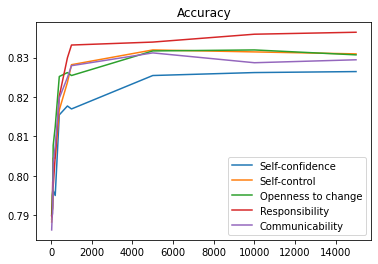

In [64]:
for i, comp in enumerate(competences) :
    plt.plot(set_size, acc_scores[i], label=comp)
    plt.legend()
    plt.title('Accuracy')
#plt.plot(set_size, precision_scores[0])
#plt.plot(set_size, recall_scores[0])
#plt.plot(set_size, f_scores[0])
plt.show()

In [65]:
for i, comp in enumerate(competences) :
    print(acc_scores[i][-1])

0.8264339152119701
0.8309226932668329
0.8306733167082294
0.8364089775561098
0.829426433915212


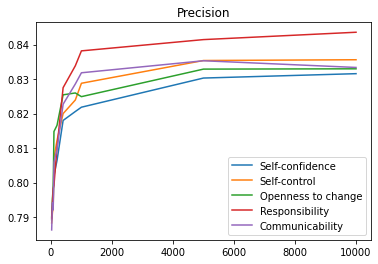

In [54]:
for i, comp in enumerate(competences) :
    plt.plot(set_size, precision_scores[i], label=comp)
    plt.legend()
    plt.title('Precision')
#plt.plot(set_size, precision_scores[0])
#plt.plot(set_size, recall_scores[0])
#plt.plot(set_size, f_scores[0])
plt.show()

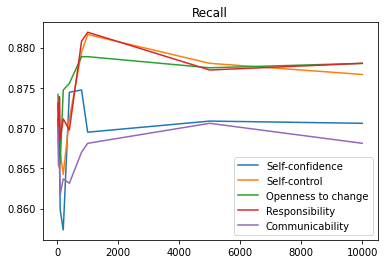

In [55]:
for i, comp in enumerate(competences) :
    plt.plot(set_size, recall_scores[i], label=comp)
    plt.legend()
    plt.title('Recall')
#plt.plot(set_size, precision_scores[0])
#plt.plot(set_size, recall_scores[0])
#plt.plot(set_size, f_scores[0])
plt.show()

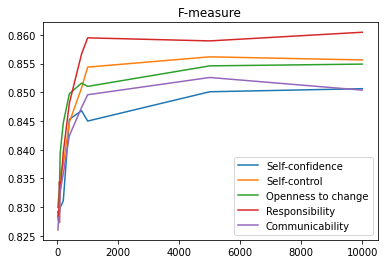

In [56]:
for i, comp in enumerate(competences) :
    plt.plot(set_size, f_scores[i], label=comp)
    plt.legend()
    plt.title('F-measure')
#plt.plot(set_size, precision_scores[0])
#plt.plot(set_size, recall_scores[0])
#plt.plot(set_size, f_scores[0])
plt.show()

In [114]:
tables[0].head()

,1_1,1_2,1_3,2_1,2_1.1,2_1.2,2_2,2_2.1,2_2.2,3_1,...,8_5,9_1,9_2,9_3,10_1,10_2,10_3,10_4,mean,feedback
1,2.000000,2.000000,3.000000,NaN,NaN,NaN,2.0,2.0,NaN,2.0,...,3.0,3.0,NaN,1.5,3.000000,3.000000,NaN,NaN,2.560606,2
2,2.333333,2.333333,2.333333,NaN,NaN,NaN,2.0,2.0,NaN,2.0,...,3.0,2.5,NaN,1.5,2.333333,2.666667,NaN,NaN,2.363636,1
3,1.666667,2.666667,2.666667,NaN,NaN,NaN,2.5,2.0,NaN,2.0,...,2.5,3.0,NaN,3.0,2.666667,3.000000,NaN,NaN,2.429293,2
4,1.666667,2.333333,2.333333,NaN,NaN,NaN,2.0,2.0,NaN,2.5,...,3.0,2.0,NaN,1.5,2.333333,2.333333,NaN,NaN,2.320707,1
5,2.000000,1.666667,2.666667,NaN,NaN,NaN,2.0,2.0,NaN,2.0,...,2.5,2.0,NaN,1.5,3.000000,3.000000,NaN,NaN,2.361111,1
